In [1]:
import sys 
print(sys.executable)

/Users/jamesgan/opt/anaconda3/envs/fyp_env/bin/python


In [2]:
import numpy

import numpy as np
import pandas
from numpy.lib.npyio import save
from PIL import Image, ImageEnhance

from scipy.ndimage import gaussian_filter
from scipy.ndimage import laplace

import matplotlib.pyplot as plt
import matplotlib
from PIL import Image

from skimage.io import imread
from skimage import measure

## Preprocessing

In [3]:
def left_align(img):
    pixels = np.asarray(img)
    if np.mean(pixels[0:256, 0:128]) < np.mean(pixels[0:256, 128:256]):
        return pixels[:, ::-1]
    return pixels 

In [4]:
def perform_contrast(img):
    enhancer = ImageEnhance.Contrast(img)
    factor = 2 #increase contrast
    img = enhancer.enhance(factor)
    return img 

In [5]:
def remove_bar(img):
    width = 0 
    while img[0, width] <= np.mean(img):
        width += 1
    return img[:, width:256]

In [6]:
def preprocess_image(img):
    img = img.resize((256,256))
    img = left_align(img)
    img = remove_bar(img)
    img = np.interp(img, [np.min(img), np.max(img)], [0, 255])
    return img

## Parameter Initialisation

In [7]:
def initialise_params(preprocessed_img):

    # initialize LSF as binary step function
    c0 = 2
    initial_lsf = c0 * np.ones(preprocessed_img.shape)
    # generate the initial region R0 as two rectangles
    initial_lsf[0:10, 0:10] = -c0 # top left corner

    # parameters
    return {
        'img': preprocessed_img,
        'initial_lsf': initial_lsf,
        'timestep': 7,  # time step
        'iter_inner': 10,
        'iter_outer': 20,
        'lmda': 8,  # coefficient of the weighted length term L(phi)
        'alfa': -5,  # coefficient of the weighted area term A(phi)
        'epsilon': 1.5,  # parameter that specifies the width of the DiracDelta function
        'sigma': 0.8,  # scale parameter in Gaussian kernel
        'potential_function': DOUBLE_WELL,
    }

In [8]:
# use single well potential p1(s)=0.5*(s-1)^2, which is good for region-based model
DOUBLE_WELL = 'double-well'

# use double-well potential in Eq. (16), which is good for both edge and region based models
SINGLE_WELL = 'single-well'

## Function that runs the DLRSE algorithm {iter_outer} times

In [9]:
def find_lsf(img: np.ndarray, initial_lsf: np.ndarray, timestep=1, iter_inner=10, iter_outer=30, lmda=5,
             alfa=-3, epsilon=1.5, sigma=0.8, potential_function=DOUBLE_WELL):
    """
    :param img: Input image as a grey scale uint8 array (0-255)
    :param initial_lsf: Array as same size as the img that contains the seed points for the LSF.
    :param timestep: Time Step
    :param iter_inner: How many iterations to run drlse before showing the output
    :param iter_outer: How many iterations to run the iter_inner
    :param lmda: coefficient of the weighted length term L(phi)
    :param alfa: coefficient of the weighted area term A(phi)
    :param epsilon: parameter that specifies the width of the DiracDelta function
    :param sigma: scale parameter in Gaussian kernal
    :param potential_function: The potential function to use in drlse algorithm. Should be SINGLE_WELL or DOUBLE_WELL
    """
    if len(img.shape) != 2:
        raise Exception("Input image should be a gray scale one")

    if len(img.shape) != len(initial_lsf.shape):
        raise Exception("Input image and the initial LSF should be in the same shape")

    if np.max(img) <= 1:
        raise Exception("Please make sure the image data is in the range [0, 255]")

    # parameters
    mu = 0.2 / timestep  # coefficient of the distance regularization term R(phi)

    img = np.array(img, dtype='float32')
    img_smooth = gaussian_filter(img, sigma)  # smooth image by Gaussian convolution
    [Iy, Ix] = np.gradient(img_smooth)
    f = np.square(Ix) + np.square(Iy)
    g = 1 / (1 + f)  # edge indicator function.

    # initialize LSF as binary step function
    phi = initial_lsf.copy()

    show_fig1(phi)
    show_fig2(phi, img)
    print('show fig 2 first time')

    if potential_function != SINGLE_WELL:
        potential_function = DOUBLE_WELL  # default choice of potential function

    # start level set evolution
    for n in range(iter_outer):
        phi = drlse_edge(phi, g, lmda, mu, alfa, epsilon, timestep, iter_inner, potential_function)
        print('show fig 2 for %i time' % n)
        draw_all(phi, img)

    # refine the zero level contour by further level set evolution with alfa=0
    alfa = 0
    iter_refine = 10
    phi = drlse_edge(phi, g, lmda, mu, alfa, epsilon, timestep, iter_refine, potential_function)
    return phi


## DLRSE Algorithm

In [10]:
def drlse_edge(phi_0, g, lmda, mu, alfa, epsilon, timestep, iters, potential_function):  # Updated Level Set Function
    """

    :param phi_0: level set function to be updated by level set evolution
    :param g: edge indicator function
    :param lmda: weight of the weighted length term
    :param mu: weight of distance regularization term
    :param alfa: weight of the weighted area term
    :param epsilon: width of Dirac Delta function
    :param timestep: time step
    :param iters: number of iterations
    :param potential_function: choice of potential function in distance regularization term.
%              As mentioned in the above paper, two choices are provided: potentialFunction='single-well' or
%              potentialFunction='double-well', which correspond to the potential functions p1 (single-well)
%              and p2 (double-well), respectively.
    """
    phi = phi_0.copy()
    [vy, vx] = np.gradient(g)
    for k in range(iters):
        phi = neumann_bound_cond(phi)
        [phi_y, phi_x] = np.gradient(phi)
        s = np.sqrt(np.square(phi_x) + np.square(phi_y))
        delta = 1e-10
        n_x = phi_x / (s + delta)  # add a small positive number to avoid division by zero
        n_y = phi_y / (s + delta)
        curvature = div(n_x, n_y)

        if potential_function == SINGLE_WELL:
            dist_reg_term = laplace(phi, mode='nearest') - curvature  # compute distance regularization term in equation (13) with the single-well potential p1.
        elif potential_function == DOUBLE_WELL:
            dist_reg_term = dist_reg_p2(phi)  # compute the distance regularization term in eqaution (13) with the double-well potential p2.
        else:
            raise Exception('Error: Wrong choice of potential function. Please input the string "single-well" or "double-well" in the drlse_edge function.')
        dirac_phi = dirac(phi, epsilon)
        area_term = dirac_phi * g  # balloon/pressure force
        edge_term = dirac_phi * (vx * n_x + vy * n_y) + dirac_phi * g * curvature
        phi += timestep * (mu * dist_reg_term + lmda * edge_term + alfa * area_term)
    return phi


def dist_reg_p2(phi):
    """
        compute the distance regularization term with the double-well potential p2 in equation (16)
    """
    [phi_y, phi_x] = np.gradient(phi)
    s = np.sqrt(np.square(phi_x) + np.square(phi_y))
    a = (s >= 0) & (s <= 1)
    b = (s > 1)
    ps = a * np.sin(2 * np.pi * s) / (2 * np.pi) + b * (s - 1)  # compute first order derivative of the double-well potential p2 in equation (16)
    dps = ((ps != 0) * ps + (ps == 0)) / ((s != 0) * s + (s == 0))  # compute d_p(s)=p'(s)/s in equation (10). As s-->0, we have d_p(s)-->1 according to equation (18)
    return div(dps * phi_x - phi_x, dps * phi_y - phi_y) + laplace(phi, mode='nearest')


def div(nx: np.ndarray, ny: np.ndarray) -> np.ndarray:
    [_, nxx] = np.gradient(nx)
    [nyy, _] = np.gradient(ny)
    return nxx + nyy


def dirac(x: np.ndarray, sigma: np.ndarray) -> np.ndarray:
    f = (1 / 2 / sigma) * (1 + np.cos(np.pi * x / sigma))
    b = (x <= sigma) & (x >= -sigma)
    return f * b


def neumann_bound_cond(f):
    """
        Make a function satisfy Neumann boundary condition
    """
    g = f.copy()

    g[np.ix_([0, -1], [0, -1])] = g[np.ix_([2, -3], [2, -3])]
    g[np.ix_([0, -1]), 1:-1] = g[np.ix_([2, -3]), 1:-1]
    g[1:-1, np.ix_([0, -1])] = g[1:-1, np.ix_([2, -3])]
    return g

## Visualisation Code

In [11]:
plt.ion()
fig1 = plt.figure(1)
fig2 = plt.figure(2)

def show_fig1(phi: np.ndarray):
    fig1.clf()
    ax1 = fig1.add_subplot(111, projection='3d')
    y, x = phi.shape
    x = np.arange(0, x, 1)
    y = np.arange(0, y, 1)
    X, Y = np.meshgrid(x, y)
    ax1.plot_surface(X, Y, -phi, rstride=2, cstride=2, color='r', linewidth=0, alpha=0.6, antialiased=True)
    ax1.contour(X, Y, phi, 0, colors='g', linewidths=2)

def show_fig2(phi: np.ndarray, img: np.ndarray):
    fig2.clf()
    contours = measure.find_contours(phi, 0)
    ax2 = fig2.add_subplot(111)
    ax2.imshow(img, interpolation='nearest', cmap=plt.get_cmap('gray'))
    for _, contour in enumerate(contours):
        ax2.plot(contour[:, 1], contour[:, 0], linewidth=2)

def draw_all(phi: np.ndarray, img: np.ndarray, pause=0):
    show_fig2(phi, img)
    # show_fig1(phi)
    plt.pause(pause)
    
def save_blacken_photo(phi: np.ndarray, img: np.ndarray):
    original_img = img.copy()
    contours = measure.find_contours(phi, 0)
    max_of_y = np.int(np.round(max(contours[0], key=lambda x: x[0]))[0])
    # contains the rightmost pixel at that particular y 
    record_array = [0] * (max_of_y + 1)
    for contour in contours[0]:
        x, y = np.int(contour[1]), round(contour[0]) 
        if record_array[y] < x:
            record_array[y] = x
    for i in range(len(record_array)):
        for j in range(record_array[i]):
            img[i,j] = 0
    matplotlib.image.imsave('image.png', img)
    matplotlib.image.imsave('original_img.png', original_img)
    return img, original_img

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

## Main Code

In [13]:
img = Image.open("mdb005.pgm")
contrasted_img = perform_contrast(img)
processed_img = preprocess_image(contrasted_img)
params = initialise_params(processed_img)
# params = two_cells_params()
phi = find_lsf(**params)

print('Show final output')
draw_all(phi, params['img'], 10)

processed_img_for_download = preprocess_image(img)
img, original_img = save_blacken_photo(phi, processed_img_for_download)

show fig 2 first time
show fig 2 for 0 time
show fig 2 for 1 time
show fig 2 for 2 time
show fig 2 for 3 time
show fig 2 for 4 time
show fig 2 for 5 time
show fig 2 for 6 time
show fig 2 for 7 time
show fig 2 for 8 time
show fig 2 for 9 time
show fig 2 for 10 time
show fig 2 for 11 time
show fig 2 for 12 time
show fig 2 for 13 time
show fig 2 for 14 time
show fig 2 for 15 time
show fig 2 for 16 time
show fig 2 for 17 time
show fig 2 for 18 time
show fig 2 for 19 time
Show final output


<ipython-input-11-264dd5cc9a3c>:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_of_y = np.int(np.round(max(contours[0], key=lambda x: x[0]))[0])
<ipython-input-11-264dd5cc9a3c>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informat

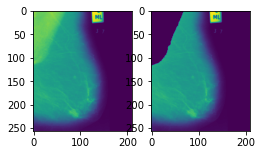

In [14]:
fig3 = plt.figure(3)

fig3.add_subplot(1,3,1)
plt.imshow(original_img)
fig3.add_subplot(1,3,2)
plt.imshow(img)